In [ ]:
!gdown 1o09HEkDBBEjsW3gN76vDYfCAKiCqpcpg

Downloading...
From: https://drive.google.com/uc?id=1o09HEkDBBEjsW3gN76vDYfCAKiCqpcpg
To: /content/financial_sentiment.zip
100% 925k/925k [00:00<00:00, 142MB/s]


In [ ]:
!unzip financial_sentiment.zip

Archive:  financial_sentiment.zip
  inflating: FinancialPhraseBank/License.txt  
  inflating: FinancialPhraseBank/README.txt  
  inflating: FinancialPhraseBank/Sentences_50Agree.txt  
  inflating: FinancialPhraseBank/Sentences_66Agree.txt  
  inflating: FinancialPhraseBank/Sentences_75Agree.txt  
  inflating: FinancialPhraseBank/Sentences_AllAgree.txt  
  inflating: all-data.csv            


In [ ]:
import pandas as pd

path = './all-data.csv'
headers = ['sentiment', 'content']
dataset = pd.read_csv(path, names=headers, encoding='ISO-8859-1')

In [ ]:
sentiment_classes = dataset['sentiment'].unique()
n_classes = len(sentiment_classes)
print(sentiment_classes)
print(n_classes)

['neutral' 'negative' 'positive']
3


In [ ]:
sentiment_status = {}
for sentiment in sentiment_classes:
  sentiment_count = dataset['sentiment'].value_counts()[sentiment]
  sentiment_status[sentiment] = sentiment_count

sentiment_status

{'neutral': 2879, 'negative': 604, 'positive': 1363}

# Pre-processing data

In [ ]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 27.0 MB/s 


In [ ]:
import re
import nltk
import unidecode

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

'''
To normalize text, several techniques are needed to be applied: 
  + Low-ercasing.
  + Punctuation removal. 
  + Stopwords removal. 
  + Stemming.
'''

english_stop_words = stopwords.words('english')
stemmer = PorterStemmer()

def text_normalize(text):
  text = text.lower()
  text = unidecode.unidecode(text)
  text = text.strip()
  text = re.sub('[^\w\s]', '', text) # which matches one character which does not belong to either the word or the whitespace group.
  text = ' '.join([word for word in text.split(' ') if word not in english_stop_words])
  text = ' '.join([stemmer.stem(word) for word in text.split(' ')])

  return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
dataset['content'] = dataset['content'].apply(lambda p: text_normalize(p)).astype(str)

dataset.content.head(10)

0    accord gran  compani plan move product russia ...
1    technopoli plan develop stage area less 100000...
2    intern electron industri compani elcoteq laid ...
3    new product plant compani would increas capac ...
4    accord compani updat strategi year 20092012  b...
5    financ aspocomp growth aspocomp aggress pursu ...
6    last quarter 2010  componenta net sale doubl e...
7    third quarter 2010  net sale increas 52  eur 2...
8    oper profit rose eur 131 mn eur 87 mn correspo...
9    oper profit total eur 211 mn  eur 186 mn 2007 ...
Name: content, dtype: object

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(dataset, test_size = 0.2, shuffle=True, random_state=1)
val_df, test_df = train_test_split(val_df, test_size=0.5, shuffle=True, random_state=1)

print(len(train_df))
print(len(val_df))
print(len(test_df))

3876
485
485


In [ ]:
import os

root_folderpath = './sentiment_data'

if os.path.exists(root_folderpath) == False:
  os.makedirs(root_folderpath)

In [ ]:
folder_name = ['train', 'val', 'test']

for name in folder_name:
  folder_path = os.path.join(root_folderpath, name)
  if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    for sentiment in sentiment_classes:
      classes_folder_path = os.path.join(folder_path, sentiment)
      if not os.path.exists(classes_folder_path):
        os.makedirs(classes_folder_path)

In [ ]:
# Save sentiment data related to sentiment_folder_path

counter_dict = dict.fromkeys(sentiment_classes, 1)

# Training dataset
for idx, row in train_df.iterrows():
  sample_sentiment = row['sentiment']
  sample_content = row['content']
  sample_filepath = os.path.join(root_folderpath, 'train', sample_sentiment, 
                                f'{sample_sentiment}_{counter_dict[sample_sentiment]}.txt')
  counter_dict[sample_sentiment] += 1
  with open(sample_filepath, 'w') as f: 
    f.write(sample_content)    

# Testing dataset
for idx, row in test_df.iterrows():
  sample_sentiment = row['sentiment']
  sample_content = row['content']
  sample_filepath = os.path.join(root_folderpath, 'test', sample_sentiment, 
                                f'{sample_sentiment}_{counter_dict[sample_sentiment]}.txt')
  counter_dict[sample_sentiment] += 1
  with open(sample_filepath, 'w') as f: 
    f.write(sample_content)    

# Validating dataset
for idx, row in val_df.iterrows():
  sample_sentiment = row['sentiment']
  sample_content = row['content']
  sample_filepath = os.path.join(root_folderpath, 'val', sample_sentiment, 
                                f'{sample_sentiment}_{counter_dict[sample_sentiment]}.txt')
  counter_dict[sample_sentiment] += 1
  with open(sample_filepath, 'w') as f: 
    f.write(sample_content)    

In [ ]:
import tensorflow as tf

BATCH_SIZE = 128
RANDOM_SEED = 1

training_dataset_path = os.path.join(root_folderpath, 'train')
testing_dataset_path = os.path.join(root_folderpath, 'test')
validating_dataset_path = os.path.join(root_folderpath, 'val')

train_dataset = tf.keras.utils.text_dataset_from_directory(
    training_dataset_path, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    seed=RANDOM_SEED
)

test_dataset = tf.keras.utils.text_dataset_from_directory(
    testing_dataset_path, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    seed=RANDOM_SEED
)

val_dataset = tf.keras.utils.text_dataset_from_directory(
    validating_dataset_path, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    seed=RANDOM_SEED
)

Found 3876 files belonging to 3 classes.
Found 485 files belonging to 3 classes.
Found 485 files belonging to 3 classes.


# Model construction

## RNN

In [ ]:
MAX_FEATURES = 5000
MAX_SEQ_LEN = 128
EMBEDDING_DIMS = 64

text_vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=MAX_FEATURES, 
    output_mode = 'int', 
    output_sequence_length = MAX_SEQ_LEN
)

train_text = train_dataset.map(lambda text, labels: text)
text_vectorize_layer.adapt(train_text)
train_text

<MapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.string, name=None)>

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return text_vectorize_layer(text), label

In [ ]:
train_dataset = train_dataset.map(vectorize_text)
val_dataset = val_dataset.map(vectorize_text)
test_dataset = test_dataset.map(vectorize_text)

In [ ]:
train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
from tensorflow import keras 
from tensorflow.keras import layers

max_features = 5000
sequence_length = 128
embedding_dim = 64

model = tf.keras.Sequential([
  text_vectorize_layer, 
  layers.Embedding(max_features + 1, embedding_dim),
  layers.SimpleRNN(32, return_sequences=True),
  layers.SimpleRNN(32, return_sequences=False),
  layers.Dense(16, activation='relu'),
  layers.Dense(3, activation='softmax')
  ])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 128)              0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 128, 64)           320064    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 128, 32)           3104      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 3)                 51        
                                                      

In [ ]:
# https://stackoverflow.com/questions/70673763/how-to-use-embedding-layer-along-with-textvectorization-in-functional-api

In [ ]:
EPOCHS = 10
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), 
              loss=keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

simpleRNN_history = model.fit(train_dataset,
                              validation_data=val_dataset,
                              epochs=EPOCHS)

Epoch 1/10
31/31 [==============================] - 12s 268ms/step - loss: 1.1254 - accuracy: 0.4487 - val_loss: 1.0236 - val_accuracy: 0.5794
Epoch 2/10
31/31 [==============================] - 8s 259ms/step - loss: 1.0321 - accuracy: 0.5957 - val_loss: 0.9983 - val_accuracy: 0.5794
Epoch 3/10
31/31 [==============================] - 13s 419ms/step - loss: 1.0130 - accuracy: 0.5957 - val_loss: 0.9923 - val_accuracy: 0.5794
Epoch 4/10
31/31 [==============================] - 12s 388ms/step - loss: 0.9903 - accuracy: 0.5957 - val_loss: 0.9791 - val_accuracy: 0.5794
Epoch 5/10
31/31 [==============================] - 14s 444ms/step - loss: 0.9804 - accuracy: 0.5957 - val_loss: 0.9704 - val_accuracy: 0.5794
Epoch 6/10
31/31 [==============================] - 8s 261ms/step - loss: 0.9711 - accuracy: 0.5957 - val_loss: 0.9636 - val_accuracy: 0.5794
Epoch 7/10
31/31 [==============================] - 10s 341ms/step - loss: 0.9644 - accuracy: 0.5957 - val_loss: 0.9581 - val_accuracy: 0.5794
E

In [ ]:
test_evaluation = model.evaluate(test_dataset)
test_evaluation

4/4 [==============================] - 0s 49ms/step - loss: 0.9557 - accuracy: 0.5773


[0.9557335376739502, 0.5773195624351501]

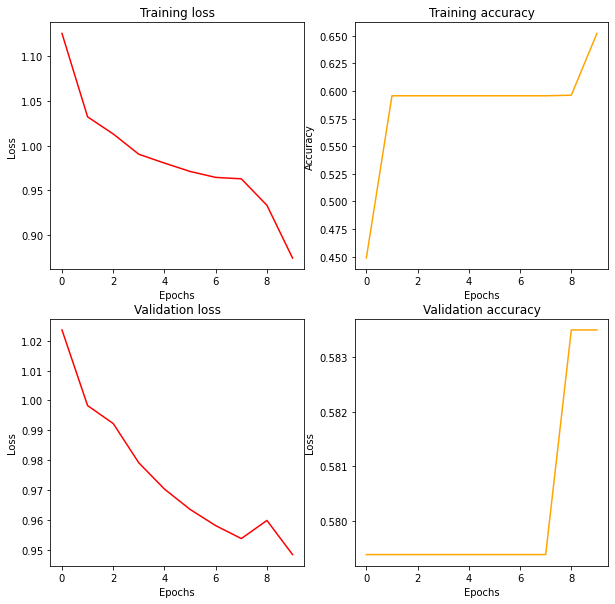

In [ ]:
import matplotlib.pyplot as plt

train_loss, train_acc = simpleRNN_history.history['loss'], simpleRNN_history.history['accuracy']
val_loss, val_acc = simpleRNN_history.history['val_loss'], simpleRNN_history.history['val_accuracy']

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.plot(train_loss, color='r')

plt.subplot(2, 2, 2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy')
plt.plot(train_acc, color='orange')

plt.subplot(2, 2, 3)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation loss')
plt.plot(val_loss, color='r')

plt.subplot(2, 2, 4)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation accuracy')
plt.plot(val_acc, color='orange')

In [ ]:
sentence = ['This is suck']
model.predict(sentence)

1/1 [==============================] - 0s 300ms/step


array([[0.18287957, 0.60896415, 0.20815633]], dtype=float32)

# Problem 2

In [ ]:
!gdown 1F6kUoxIeDbc_oQO2ADtyIetzQkRdIc0r

Downloading...
From: https://drive.google.com/uc?id=1F6kUoxIeDbc_oQO2ADtyIetzQkRdIc0r
To: /content/weather_forecast.zip
100% 2.34M/2.34M [00:00<00:00, 78.4MB/s]


In [ ]:
!unzip './weather_forecast.zip'

Archive:  ./weather_forecast.zip
  inflating: weatherHistory.csv      


In [ ]:
import os   
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split

RANDOM_SEED = 1
tf.random.set_seed(RANDOM_SEED)

In [ ]:
dataset_filepath = './weatherHistory.csv' 
df = pd.read_csv(dataset_filepath)
df

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.
...,...,...,...,...,...,...,...,...,...,...,...,...
96448,2016-09-09 19:00:00.000 +0200,Partly Cloudy,rain,26.016667,26.016667,0.43,10.9963,31.0,16.1000,0.0,1014.36,Partly cloudy starting in the morning.
96449,2016-09-09 20:00:00.000 +0200,Partly Cloudy,rain,24.583333,24.583333,0.48,10.0947,20.0,15.5526,0.0,1015.16,Partly cloudy starting in the morning.
96450,2016-09-09 21:00:00.000 +0200,Partly Cloudy,rain,22.038889,22.038889,0.56,8.9838,30.0,16.1000,0.0,1015.66,Partly cloudy starting in the morning.
96451,2016-09-09 22:00:00.000 +0200,Partly Cloudy,rain,21.522222,21.522222,0.60,10.5294,20.0,16.1000,0.0,1015.95,Partly cloudy starting in the morning.


In [ ]:
def slicing_window(df, df_start_idx, df_end_idx, input_size, label_size, offset):
    features = []
    labels = []

    window_size = input_size + offset 

    if df_end_idx == None:
        df_end_idx = len(df) - window_size 
    
    for idx in range(df_start_idx, df_end_idx):
        feature_end_idx = idx + input_size 
        label_start_idx = idx + window_size - label_size 

        feature = df[idx:feature_end_idx] 
        label = df[label_start_idx:(idx+window_size)]

        features.append(feature) 
        labels.append(label)
        
    features = np.expand_dims(np.array(features), -1) 
    labels = np.array(labels)

    return features, labels

In [ ]:
univariate_df = df['Temperature (C)']
univariate_df.index = df['Formatted Date'] 
univariate_df

Formatted Date
2006-04-01 00:00:00.000 +0200     9.472222
2006-04-01 01:00:00.000 +0200     9.355556
2006-04-01 02:00:00.000 +0200     9.377778
2006-04-01 03:00:00.000 +0200     8.288889
2006-04-01 04:00:00.000 +0200     8.755556
                                   ...    
2016-09-09 19:00:00.000 +0200    26.016667
2016-09-09 20:00:00.000 +0200    24.583333
2016-09-09 21:00:00.000 +0200    22.038889
2016-09-09 22:00:00.000 +0200    21.522222
2016-09-09 23:00:00.000 +0200    20.438889
Name: Temperature (C), Length: 96453, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6c726dda90>],
      dtype=object)

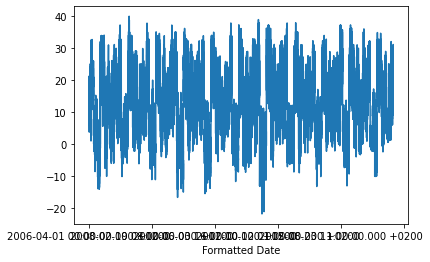

In [ ]:
univariate_df.plot(subplots=True)

In [ ]:
INPUT_SIZE = 6 
LABEL_SIZE = 1 
OFFSET = 1 
BATCH_SIZE = 32

In [ ]:
dataset_length = len(univariate_df) 
TRAIN_SIZE = 0.7 
VAL_SIZE = 0.2

TRAIN_END_IDX = int(TRAIN_SIZE * dataset_length) 
VAL_END_IDX = int(VAL_SIZE * dataset_length) + TRAIN_END_IDX

X_train, y_train = slicing_window(univariate_df, 
                                  df_start_idx=0,
                                  df_end_idx=TRAIN_END_IDX,
                                  input_size=INPUT_SIZE,
                                  label_size=LABEL_SIZE,
                                  offset=OFFSET)

X_val, y_val = slicing_window(univariate_df, 
                                  df_start_idx=TRAIN_END_IDX,
                                  df_end_idx=VAL_END_IDX,
                                  input_size=INPUT_SIZE,
                                  label_size=LABEL_SIZE,
                                  offset=OFFSET)

X_test, y_test = slicing_window(univariate_df, 
                                  df_start_idx=VAL_END_IDX,
                                  df_end_idx=None,
                                  input_size=INPUT_SIZE,
                                  label_size=LABEL_SIZE,
                                  offset=OFFSET)

In [ ]:
X_train.shape

(67517, 6, 1)

In [ ]:
X_train.shape[-2:]

(6, 1)

In [ ]:
X_train

array([[[ 9.47222222],
        [ 9.35555556],
        [ 9.37777778],
        [ 8.28888889],
        [ 8.75555556],
        [ 9.22222222]],

       [[ 9.35555556],
        [ 9.37777778],
        [ 8.28888889],
        [ 8.75555556],
        [ 9.22222222],
        [ 7.73333333]],

       [[ 9.37777778],
        [ 8.28888889],
        [ 8.75555556],
        [ 9.22222222],
        [ 7.73333333],
        [ 8.77222222]],

       ...,

       [[17.        ],
        [15.35555556],
        [14.27222222],
        [13.8       ],
        [14.93333333],
        [16.87222222]],

       [[15.35555556],
        [14.27222222],
        [13.8       ],
        [14.93333333],
        [16.87222222],
        [17.8       ]],

       [[14.27222222],
        [13.8       ],
        [14.93333333],
        [16.87222222],
        [17.8       ],
        [18.93333333]]])

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalize_layer = tf.keras.layers.Normalization(axis=-1)
normalize_layer.adapt(np.vstack((X_train, X_val, X_test)))

## RNN

In [ ]:
model = tf.keras.Sequential(name='rnn_model')
model.add(tf.keras.Input(shape=X_train.shape[-2:], name='input_layer'))
model.add(normalize_layer)
model.add(tf.keras.layers.SimpleRNN(6, return_sequences=True, name='rnn_layer_1')) 
model.add(tf.keras.layers.SimpleRNN(6, return_sequences=True, name='rnn_layer_2')) 
model.add(tf.keras.layers.SimpleRNN(6, return_sequences=False, name='rnn_layer_3')) 
model.add(tf.keras.layers.Dense(1, name='output_layer'))
model.summary()

Model: "rnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  multiple                 3         
 n)                                                              
                                                                 
 rnn_layer_1 (SimpleRNN)     (None, 6, 6)              48        
                                                                 
 rnn_layer_2 (SimpleRNN)     (None, 6, 6)              78        
                                                                 
 rnn_layer_3 (SimpleRNN)     (None, 6)                 78        
                                                                 
 output_layer (Dense)        (None, 1)                 7         
                                                                 
Total params: 214
Trainable params: 211
Non-trainable params: 3
___________________________________________________________

In [ ]:
EPOCHS=20
LR=1e-4

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR), 
    loss=tf.keras.losses.MeanSquaredError()
)

history=model.fit(train_ds, 
                  validation_data=val_ds,
                  epochs=EPOCHS, 
                  verbose=2)

In [ ]:
test_evaluation = model.evaluate(test_ds)
test_evaluation

302/302 [==============================] - 1s 4ms/step - loss: 7.9817


7.981687545776367

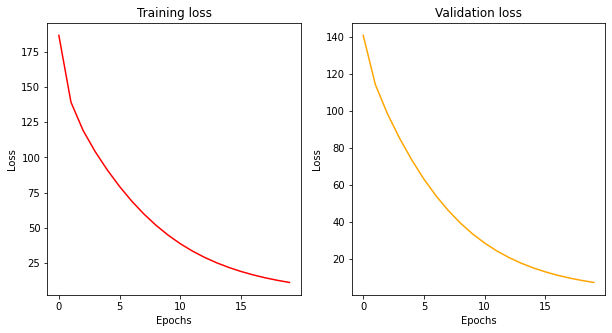

In [ ]:
train_loss = history.history['loss']# Đọc thông tin loss trên tập train
val_loss = history.history['val_loss'] # Đọc thông tin loss trên tập val

plt.figure(figsize=(10, 5)) # Cài đặt kích thước khung ảnh

plt.subplot(1, 2, 1) # Khởi tạo khung ảnh cho training loss
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Loss') # Hiển thị tên trục tung là 'Loss'
plt.title('Training loss') # Hiển thị title của khung ảnh hiện tại là 'Training Loss'
plt.plot(train_loss, color='red') # Vẽ đường giá trị loss trên tập train qua từng epoch (đường vẽ màu đỏ)

plt.subplot(1, 2, 2) # Khởi tạo khung ảnh cho val loss
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Loss') # Hiển thị tên trục tung là 'Loss'
plt.title('Validation loss') # Hiển thị title của khung ảnh hiện tại là 'Validation loss'
plt.plot(val_loss, color='orange') # Vẽ đường giá trị loss trên tập val qua từng epoch (đường vẽ màu đỏ)

plt.show() # Hiển thị 2 khung ảnh nhỏ

In [ ]:
def create_time_steps(length):

  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])

  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)

  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])

  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')

  return plt

1/1 [==============================] - 0s 297ms/step


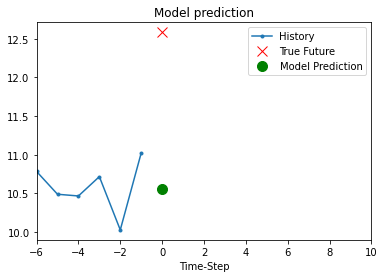

1/1 [==============================] - 0s 16ms/step


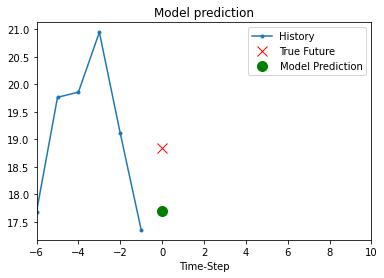

1/1 [==============================] - 0s 17ms/step


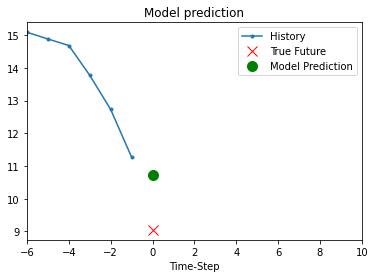

1/1 [==============================] - 0s 16ms/step


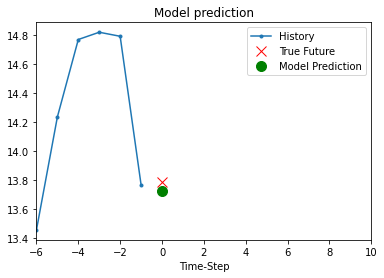

1/1 [==============================] - 0s 18ms/step


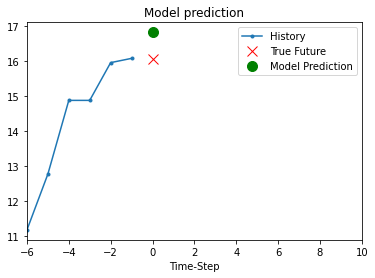

1/1 [==============================] - 0s 16ms/step


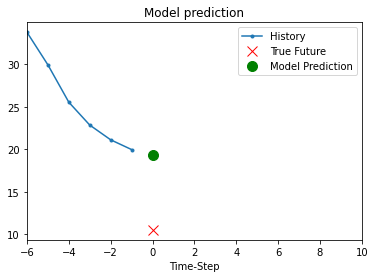

1/1 [==============================] - 0s 20ms/step


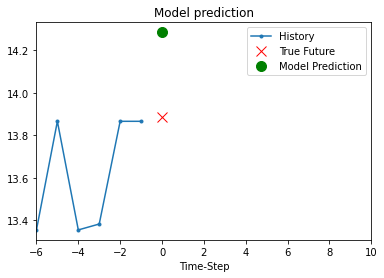

1/1 [==============================] - 0s 15ms/step


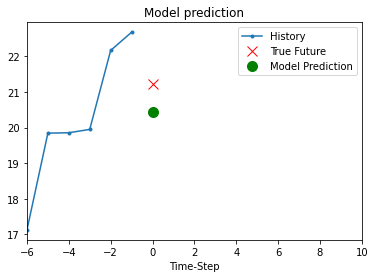

1/1 [==============================] - 0s 16ms/step


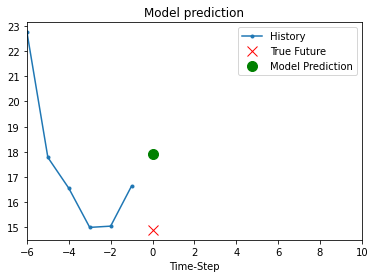

1/1 [==============================] - 0s 17ms/step


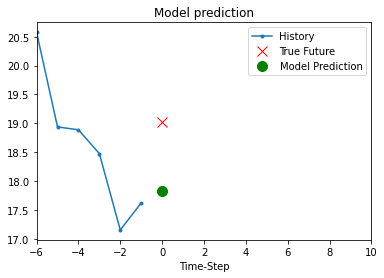

In [ ]:
for X, y in test_ds.take(10):
  plot = show_plot([X[0].numpy(), y[0].numpy(),
                    model.predict(X)[0]], 0, 'Model prediction')
  plot.show()

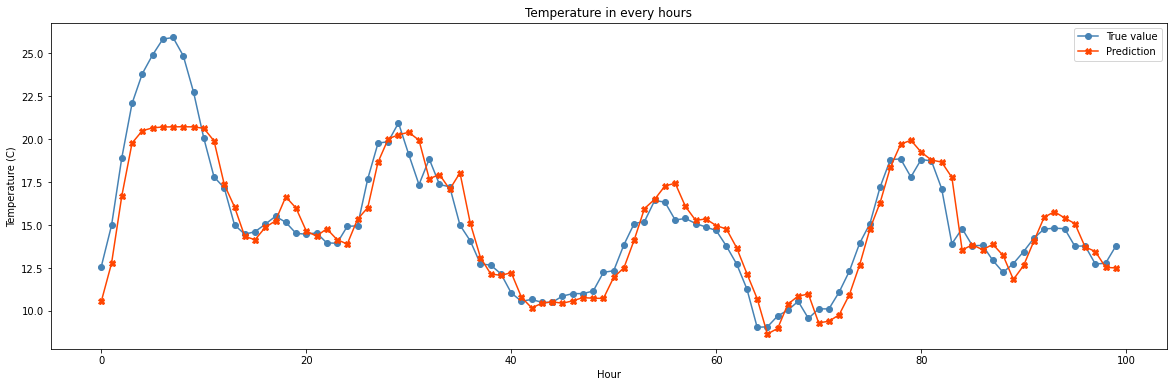

In [ ]:
def plot_difference(y, pred):
    plt.figure(figsize=(20, 6))
    times = range(len(y))
    y_to_plot = y.flatten()
    pred_to_plot = pred.flatten()

    plt.plot(times, y_to_plot, color='steelblue', marker='o', label='True value')
    plt.plot(times, pred_to_plot, color='orangered', marker='X', label='Prediction')

    plt.title('Temperature in every hours')
    plt.xlabel('Hour')
    plt.ylabel('Temperature (C)')
    plt.legend()
    plt.show()

plot_difference(y_test[:100], model.predict(X_test[:100], verbose=0))

## LSTM

In [ ]:
lstm_model = tf.keras.Sequential(name='lstm_model')
lstm_model.add(tf.keras.Input(shape=X_train.shape[-2:], name='input_layer'))
lstm_model.add(normalize_layer)
lstm_model.add(tf.keras.layers.LSTM(6, return_sequences=True, name='lstm_layer_1')) 
lstm_model.add(tf.keras.layers.LSTM(6, return_sequences=True, name='lstm_layer_2')) 
lstm_model.add(tf.keras.layers.LSTM(6, return_sequences=False, name='lstm_layer_3')) 
lstm_model.add(tf.keras.layers.Dense(1, name='output_layer'))
lstm_model.summary()

Model: "lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  multiple                 3         
 n)                                                              
                                                                 
 lstm_layer_1 (LSTM)         (None, 6, 6)              192       
                                                                 
 lstm_layer_2 (LSTM)         (None, 6, 6)              312       
                                                                 
 lstm_layer_3 (LSTM)         (None, 6)                 312       
                                                                 
 output_layer (Dense)        (None, 1)                 7         
                                                                 
Total params: 826
Trainable params: 823
Non-trainable params: 3
__________________________________________________________

In [ ]:
EPOCHS=20
LR=1e-4

lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR), 
    loss=tf.keras.losses.MeanSquaredError()
)

history=lstm_model.fit(train_ds, 
                  validation_data=val_ds,
                  epochs=EPOCHS, 
                  verbose=2)

In [ ]:
lstm_model.evaluate(test_ds)

302/302 [==============================] - 1s 4ms/step - loss: 7.6584


7.658380031585693

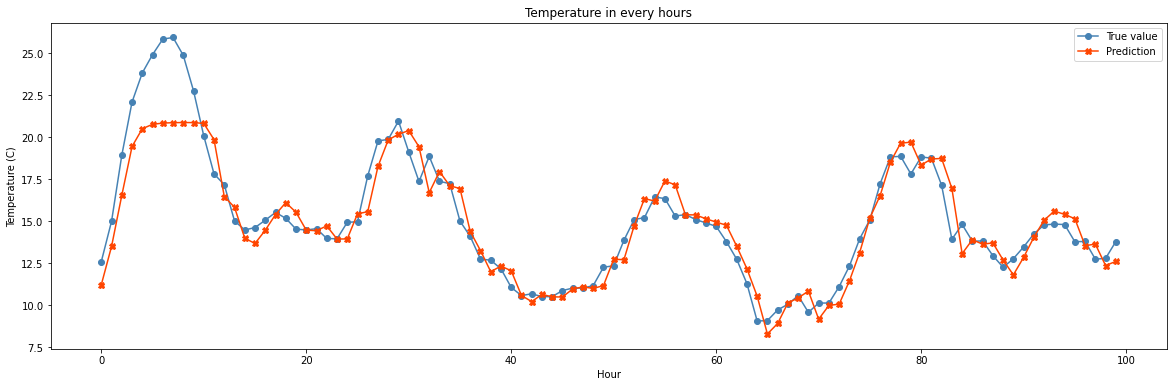

In [ ]:
plot_difference(y_test[:100], lstm_model.predict(X_test[:100], verbose=0))

## Bi-LSTM

In [ ]:
bmodel = tf.keras.Sequential(name='bi_lstm_model')
bmodel.add(tf.keras.Input(shape=X_train.shape[-2:], name='input_layer'))
bmodel.add(normalize_layer)
bmodel.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6, return_sequences=True, name='bi_lstm_layer_1'))) 
bmodel.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6, return_sequences=True, name='bi_lstm_layer_1'))) 
bmodel.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6, return_sequences=False, name='bi_lstm_layer_1'))) 
bmodel.add(tf.keras.layers.Dense(1, name='output_layer'))
bmodel.summary()

Model: "bi_lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  multiple                 3         
 n)                                                              
                                                                 
 bidirectional (Bidirectiona  (None, 6, 12)            384       
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 6, 12)            912       
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 12)               912       
 nal)                                                            
                                                                 
 output_layer (Dense)        (None, 1)               

In [ ]:
EPOCHS=20
LR=1e-4

bmodel.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR), 
    loss=tf.keras.losses.MeanSquaredError()
)

history=bmodel.fit(train_ds, 
                  validation_data=val_ds,
                  epochs=EPOCHS, 
                  verbose=2)

Epoch 1/20
2110/2110 - 36s - loss: 158.4316 - val_loss: 100.5103 - 36s/epoch - 17ms/step
Epoch 2/20
2110/2110 - 25s - loss: 97.6593 - val_loss: 72.5749 - 25s/epoch - 12ms/step
Epoch 3/20
2110/2110 - 24s - loss: 74.8708 - val_loss: 55.0201 - 24s/epoch - 11ms/step
Epoch 4/20
2110/2110 - 25s - loss: 58.1566 - val_loss: 41.6745 - 25s/epoch - 12ms/step
Epoch 5/20
2110/2110 - 24s - loss: 45.0320 - val_loss: 31.5264 - 24s/epoch - 11ms/step
Epoch 6/20
2110/2110 - 24s - loss: 34.6819 - val_loss: 23.7935 - 24s/epoch - 11ms/step
Epoch 7/20
2110/2110 - 24s - loss: 26.6133 - val_loss: 17.7628 - 24s/epoch - 11ms/step
Epoch 8/20
2110/2110 - 24s - loss: 20.4730 - val_loss: 13.5124 - 24s/epoch - 11ms/step
Epoch 9/20
2110/2110 - 24s - loss: 16.0376 - val_loss: 10.4986 - 24s/epoch - 12ms/step
Epoch 10/20
2110/2110 - 24s - loss: 12.7351 - val_loss: 8.3035 - 24s/epoch - 11ms/step
Epoch 11/20
2110/2110 - 24s - loss: 10.2577 - val_loss: 6.6975 - 24s/epoch - 11ms/step
Epoch 12/20
2110/2110 - 24s - loss: 8.397

In [ ]:
bmodel.evaluate(test_ds)

302/302 [==============================] - 2s 5ms/step - loss: 1.9822


1.9822310209274292

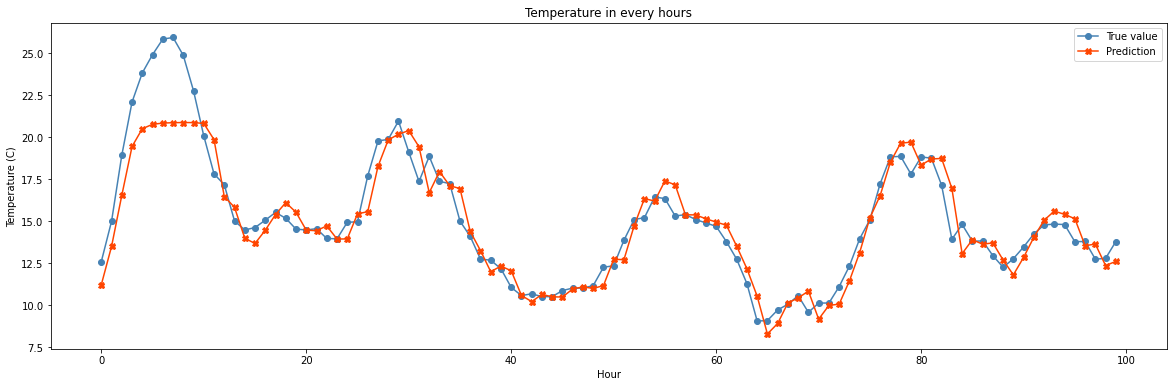

In [ ]:
plot_difference(y_test[:100], lstm_model.predict(X_test[:100], verbose=0))